In [1]:
# Ref. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [2]:
'''
Instead of random initializaion, we initialize the network 
with a pretrained network, like the one that is trained 
on imagenet 1000 dataset.

So, we will freeze the weights for all of the network 
except that of the final fully connected layer. 
This last fully connected layer is replaced 
with a new one with random weights and only 
this layer is trained.
'''

'\nInstead of random initializaion, we initialize the network \nwith a pretrained network, like the one that is trained \non imagenet 1000 dataset.\n\nSo, we will freeze the weights for all of the network \nexcept that of the final fully connected layer. \nThis last fully connected layer is replaced \nwith a new one with random weights and only \nthis layer is trained.\n'

In [1]:
from __future__ import print_function, division

### download the data

In [19]:
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2018-06-24 10:54:42--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.115.85, 13.32.115.26, 13.32.115.23, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.115.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45,10M   448KB/s    in 75s     

2018-06-24 10:55:58 (612 KB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [20]:
!ls

hymenoptera_data.zip  Transfer_Learning_Tutorial_with_PyTorch.ipynb


In [23]:
! unzip hymenoptera_data.zip > /dev/null

In [24]:
!ls

hymenoptera_data      Transfer_Learning_Tutorial_with_PyTorch.ipynb
hymenoptera_data.zip


In [25]:
data_dir = 'hymenoptera_data'

In [26]:
import torch
from torchvision import datasets, models, transforms

### preprocessing the data

In [27]:
# data augmentation and normalization for training dataset
# just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])
}

/home/ivan/Environments/CV/lib/python3.5/site-packages/torchvision/transforms/transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


In [28]:
import os

In [29]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size=4,
                                             shuffle=True, 
                                             num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available()
                     else 'cpu')

In [30]:
# visualizing some images
import numpy as np
import torchvision
import matplotlib.pyplot as plt

plt.ion()

In [35]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [36]:
inputs, classes = next(iter(dataloaders['train']))

In [37]:
out = torchvision.utils.make_grid(inputs)

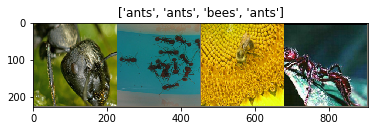

In [38]:
imshow(out, title=[class_names[x] for x in classes])

### training the model

In [52]:
import time
import copy 
from torchvision import models

In [58]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # each epoch has a training and validation phase
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()    
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            #iterating over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero the parameter gradients
                optimizer.zero_grad()
                
                #forward and track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _ , preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward + optimize if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

### visualizing the model predictions

In [68]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _ , preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### finetuning the convnet

In [60]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

In [61]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [62]:
model_ft.fc = nn.Linear(num_ftrs, 2)

In [63]:
model_ft = model_ft.to(device)

In [64]:
criterion = nn.CrossEntropyLoss()

In [65]:
# all parameter are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [66]:
# decay lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### training and evaluate

In [50]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5511 Acc: 0.7418
val Loss: 0.5570 Acc: 0.7712

Epoch 1/4
----------
train Loss: 0.7332 Acc: 0.7377
val Loss: 0.2966 Acc: 0.8627

Epoch 2/4
----------
train Loss: 0.4144 Acc: 0.7910
val Loss: 0.3020 Acc: 0.8824

Epoch 3/4
----------
train Loss: 0.7595 Acc: 0.7459
val Loss: 0.6067 Acc: 0.8301

Epoch 4/4
----------
train Loss: 0.7044 Acc: 0.7828
val Loss: 0.3318 Acc: 0.9020

Training complete in 12m 18s
Best val Acc: 0.901961


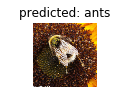

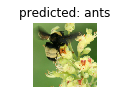

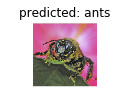

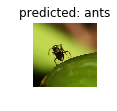

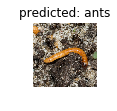

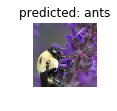

In [69]:
visualize_model(model_ft)

### convnet as fixed feature extractor

In [70]:
'''
Here, we need to freeze all the network except the final layer. 
We need to set requires_grad == False to freeze the parameters so 
that the gradients are not computed in backward().
'''

'\nHere, we need to freeze all the network except the final layer. \nWe need to set requires_grad == False to freeze the parameters so \nthat the gradients are not computed in backward().\n'

In [71]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [72]:
for param in model_conv.parameters():
    param.requires_grad = False

In [73]:
"parameters of newly constructed modules have requires_grad=True by default"

'parameters of newly constructed modules have requires_grad=True by default'

In [74]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

In [75]:
model_conv = model_conv.to(device)

In [76]:
criterion = nn.CrossEntropyLoss()

In [77]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [78]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [79]:
? lr_scheduler.StepLR()

In [81]:
model_conv = train_model(model_conv, criterion, optimizer_conv, 
                        exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5799 Acc: 0.7254
val Loss: 0.3788 Acc: 0.8039

Epoch 1/4
----------
train Loss: 0.5207 Acc: 0.7910
val Loss: 0.2177 Acc: 0.9412

Epoch 2/4
----------
train Loss: 0.4726 Acc: 0.7582
val Loss: 0.3681 Acc: 0.8627

Epoch 3/4
----------
train Loss: 0.4826 Acc: 0.7623
val Loss: 0.2105 Acc: 0.9346

Epoch 4/4
----------
train Loss: 0.5215 Acc: 0.7787
val Loss: 0.3391 Acc: 0.8627

Training complete in 6m 10s
Best val Acc: 0.941176


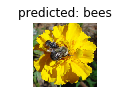

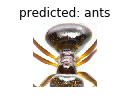

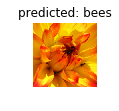

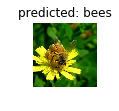

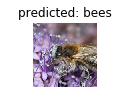

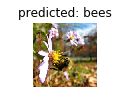

In [82]:
#visualize_model
visualize_model(model_conv)
plt.ioff()
plt.show()
